In [1092]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from prophet import Prophet

In [1093]:
df = pd.read_csv("Dataset 1_EV charging reports.csv", sep=';')
df.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


### ========================= Data Preparation =========================

In [1094]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 806.1+ KB


In [1095]:
#Null Values
print(f"df shape: {df.shape}")
df.isnull().sum()

df shape: (6878, 15)


session_ID              0
Garage_ID               0
User_ID                 0
User_type               0
Shared_ID            5466
Start_plugin            0
Start_plugin_hour       0
End_plugout            34
End_plugout_hour       34
El_kWh                  0
Duration_hours         34
month_plugin            0
weekdays_plugin         0
Plugin_category         0
Duration_category      34
dtype: int64

In [1096]:
#A big quantity of null values --> drop
df.drop(['Shared_ID'], axis=1, inplace=True)
df.isnull().sum()

session_ID            0
Garage_ID             0
User_ID               0
User_type             0
Start_plugin          0
Start_plugin_hour     0
End_plugout          34
End_plugout_hour     34
El_kWh                0
Duration_hours       34
month_plugin          0
weekdays_plugin       0
Plugin_category       0
Duration_category    34
dtype: int64

In [1097]:
#the following columns will not be useful to us: session_ID, Duration_category, Plugin_category, weekdays_plugin, 
#                                                month_plugin, User_type

no_useful = ["session_ID", "Duration_category", "Plugin_category", "weekdays_plugin", "month_plugin", "User_type"]
df.drop(no_useful, axis=1, inplace=True)
display(df.head())
df.info()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
0,AdO3,AdO3-4,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05"
1,AdO3,AdO3-4,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667"
2,AdO3,AdO3-4,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889"
3,AdO3,AdO3-2,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222"
4,AdO3,AdO3-2,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Garage_ID          6878 non-null   object 
 1   User_ID            6878 non-null   object 
 2   Start_plugin       6878 non-null   object 
 3   Start_plugin_hour  6878 non-null   int64  
 4   End_plugout        6844 non-null   object 
 5   End_plugout_hour   6844 non-null   float64
 6   El_kWh             6878 non-null   object 
 7   Duration_hours     6844 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 430.0+ KB


In [1098]:
#El_kWh: object --> float
#Duration_hours: objetc --> float
#Start_plugin and End_plugout: object --> datetime

df["El_kWh"] = df['El_kWh'].str.replace(',', '.').astype(float)

df["Duration_hours"] = df['Duration_hours'].str.replace(',', '.').astype(float)

df['Start_plugin'] = df['Start_plugin'].str.split(' ').str[0]
df["Start_plugin"] = pd.to_datetime(df["Start_plugin"])
# df["Start_plugin"] = df["Start_plugin"].dt.strftime('%d/%m/%Y')
# df["Start_plugin"] = pd.to_datetime(df["Start_plugin"], format='%d/%m/%Y')


df['End_plugout'] = df['End_plugout'].str.split(' ').str[0]
df["End_plugout"] = pd.to_datetime(df["End_plugout"])
# df["End_plugout"] = df["End_plugout"].dt.strftime('%d/%m/%Y')
# df["End_plugout"] = pd.to_datetime(df["End_plugout"], format='%d/%m/%Y')

display(df.head())
df.info()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Garage_ID          6878 non-null   object        
 1   User_ID            6878 non-null   object        
 2   Start_plugin       6878 non-null   datetime64[ns]
 3   Start_plugin_hour  6878 non-null   int64         
 4   End_plugout        6844 non-null   datetime64[ns]
 5   End_plugout_hour   6844 non-null   float64       
 6   El_kWh             6878 non-null   float64       
 7   Duration_hours     6844 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 430.0+ KB


In [1099]:
#Creating a new column that is also going to be predicted
#The dataset is from Norway, so we search about the cost of 1khw there and we r using the found values (in R$) to create the new feature
#The source link is below  

random_number = round(random.uniform(1, 1.4),2) 
#The cost of 1kwh in Norway is about R$1,00 to R$1,40

df['Cost(R$)'] = [kwh*random_number for kwh in df['El_kWh']]

In [1100]:
df.head()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,Cost(R$)
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000,0.3360
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667,0.9744
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389,33.4544
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722,17.4272
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556,4.0544


https://pt.countryeconomy.com/energia-e-meio-ambiente/eletricidade-preco-domestica/noruega

In [1101]:
df[df['Garage_ID']=='AdO3']

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,Cost(R$)
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000,0.3360
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667,0.9744
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389,33.4544
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722,17.4272
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556,4.0544
...,...,...,...,...,...,...,...,...,...
6804,AdO3,AdO3-2,2020-01-29,19,2020-01-30,9.0,14.75,13.366111,16.5200
6807,AdO3,AdO3-4,2020-01-29,20,2020-01-30,11.0,13.36,15.498611,14.9632
6846,AdO3,AdO3-1,2020-01-30,19,2020-01-31,7.0,3.97,11.818333,4.4464
6848,AdO3,AdO3-2,2020-01-30,19,2020-01-30,21.0,7.39,1.972778,8.2768


In [1102]:
set(df['Garage_ID'])

{'AdA1',
 'AdA6',
 'AdO1',
 'AdO3',
 'AsO10',
 'AsO2',
 'AsO4',
 'AsO6',
 'AsO8',
 'Bl2',
 'Bl7',
 'MS1',
 'MS11',
 'MS22',
 'NR1',
 'Ris',
 'SR14',
 'SR2',
 'SR4',
 'UT1',
 'UT15',
 'UT2',
 'UT7',
 'UT9'}

#### We will use the initial of "Start_plugin" data to create our time series dataset and the sum of energy consumption and cost

In [1103]:
#Creating a dataframe for each garage and filtering a column of the total energy consumption and total cost by data
time_series_df = {}

for id in df['Garage_ID'].unique():
    df_by_id = df[df['Garage_ID'] == id]
    df_by_id = pd.DataFrame(df_by_id.groupby(df_by_id['Start_plugin'].dt.date)['El_kWh'].sum())
    df_by_id['id_Garage'] = id
    time_series_df[id] = df_by_id


    # time_series_df[id] = df[df['Garage_ID'] == id].copy()
    # time_series_df[id] = pd.DataFrame(df.groupby(df['Start_plugin'].dt.date)['El_kWh'].sum())
    # time_series_df[id]['id_Garage'] = id

In [1104]:
time_series_df['AsO8'] #searching by Garage_ID and viewing the dataframe

,El_kWh,id_Garage
Start_plugin,,
2019-10-09,17.31,AsO8
2019-10-13,22.15,AsO8
2019-10-14,23.84,AsO8
2019-10-18,25.26,AsO8
2019-10-25,16.30,AsO8
...,...,...
2020-01-27,8.07,AsO8
2020-01-28,7.30,AsO8
2020-01-29,61.70,AsO8


### ======================= TimeSeries - PROPHET =======================


In [1105]:
#Prophet model requires you to change the name of the time data for "ds" and the target data for "y"
def prophet_ts(df):
    df = df.reset_index()
    df_prophet = df[['Start_plugin', 'El_kWh']]
    df_prophet.rename(columns={'Start_plugin':'ds',
                       'El_kWh':'y'}, inplace=True)
    
    #data column to datatime type
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    print(f"data shape: {df_prophet.shape}")
    #Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False) #daily data
    model.add_country_holidays(country_name='NOR') #data from Norway
    model.fit(df_prophet)

    #Dataframe for predictions
    future = model.make_future_dataframe(periods=90) #90 days
    forecast = model.predict(future)

    #plot
    fig = model.plot(forecast)
    plt.title(f'PREDICTION ELETRECITY (khw) - EV CHARGING - {df.id_Garage[1]} GARAGE')
    plt.xlabel('Data')
    plt.ylabel('kwh')
    plt.show()

15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing


data shape: (237, 2)


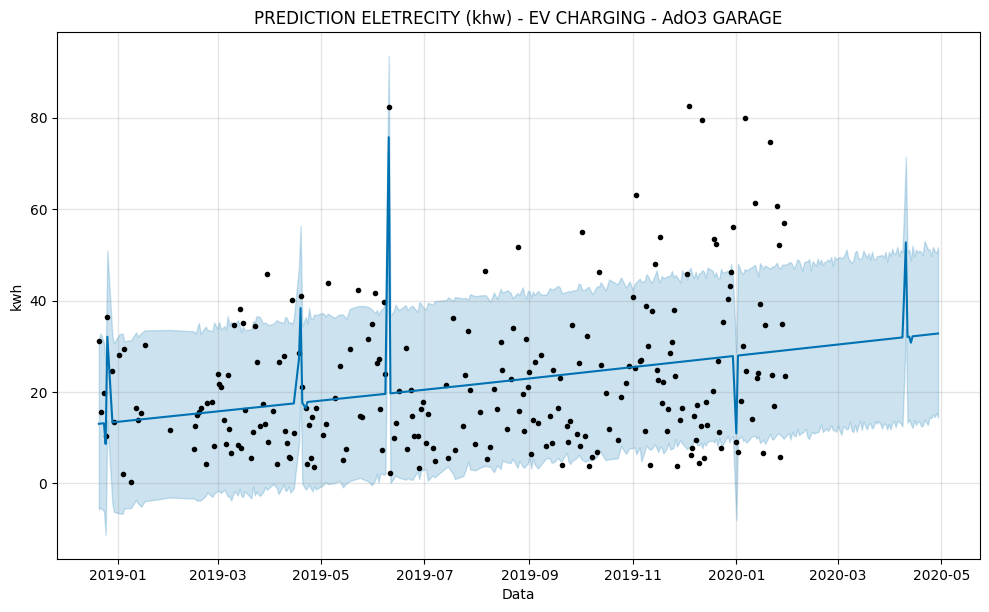

15:40:37 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing


data shape: (371, 2)


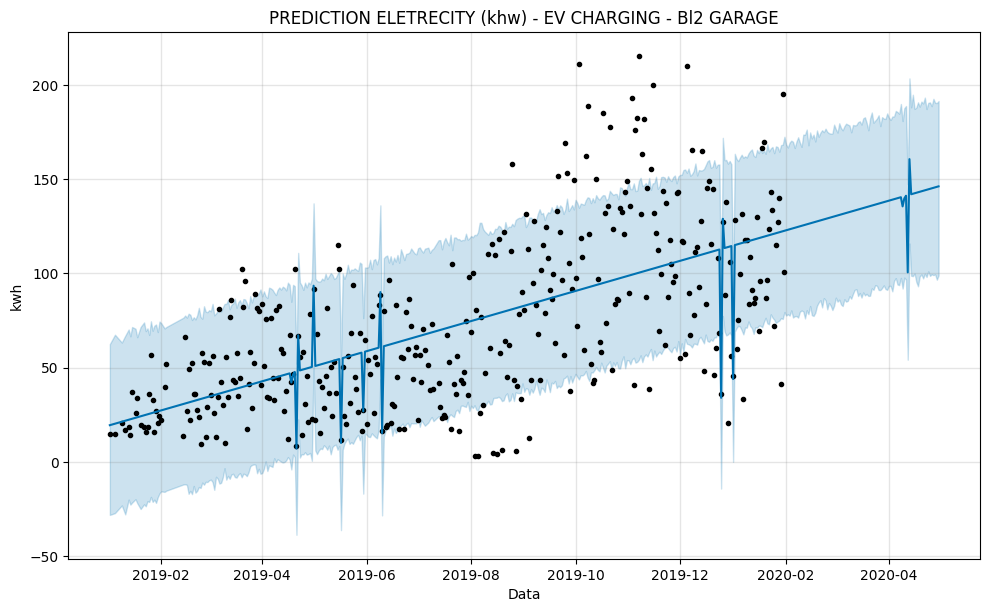

15:40:37 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing


data shape: (310, 2)


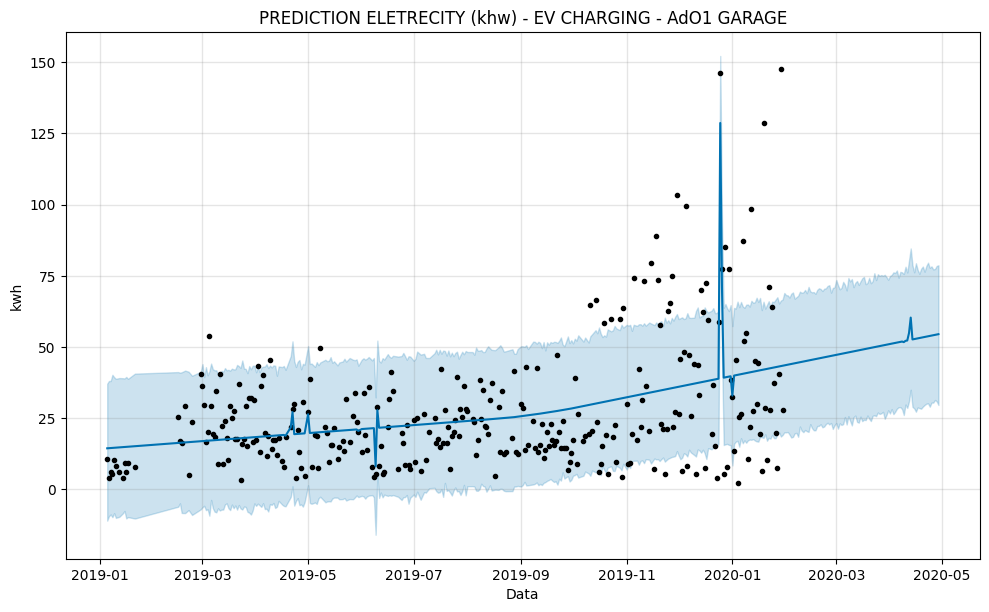

15:40:38 - cmdstanpy - INFO - Chain [1] start processing
15:40:38 - cmdstanpy - INFO - Chain [1] done processing


data shape: (269, 2)


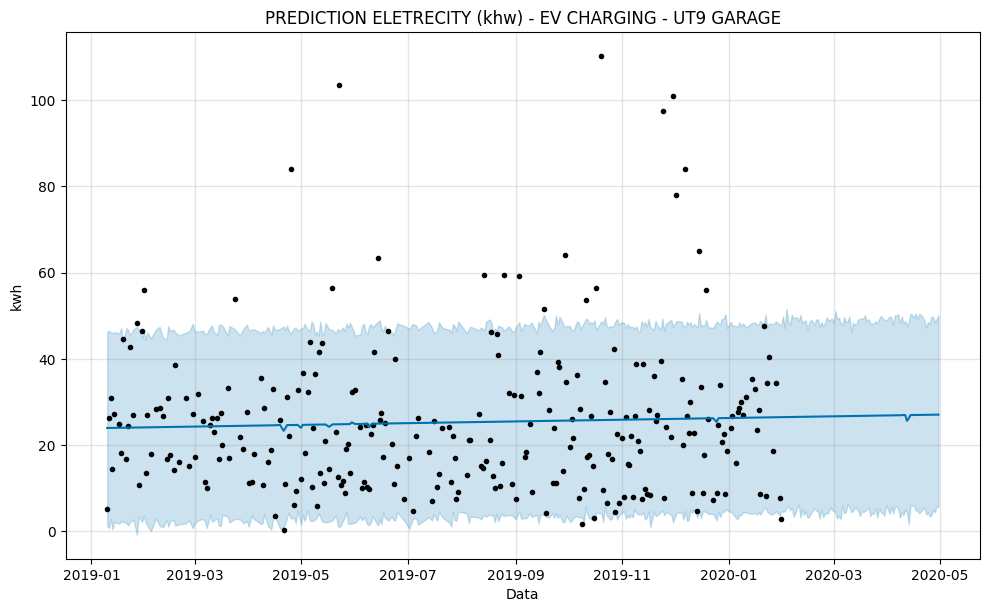

15:40:38 - cmdstanpy - INFO - Chain [1] start processing
15:40:38 - cmdstanpy - INFO - Chain [1] done processing


data shape: (325, 2)


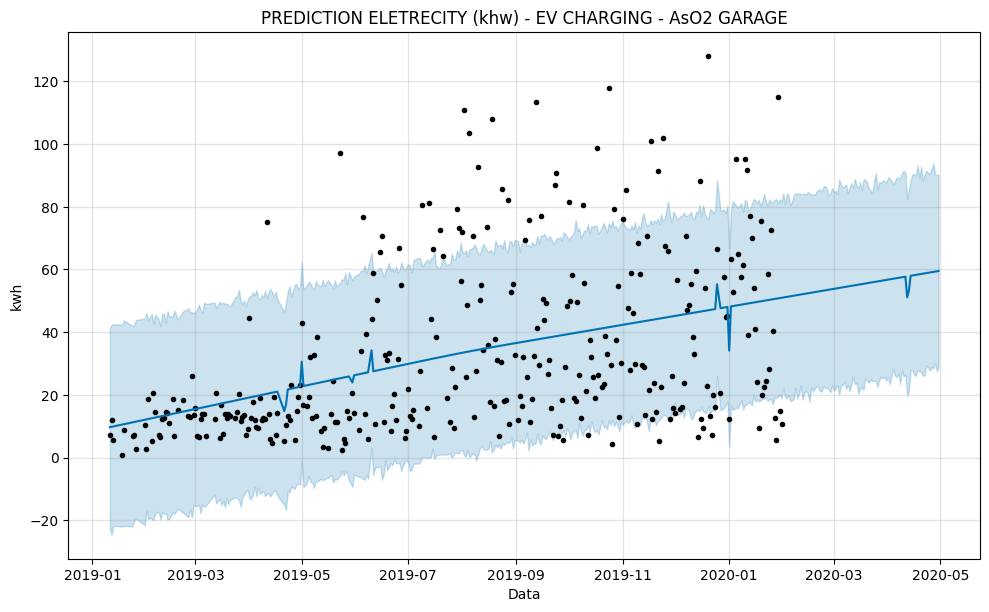

15:40:39 - cmdstanpy - INFO - Chain [1] start processing


data shape: (16, 2)


15:40:39 - cmdstanpy - INFO - Chain [1] done processing


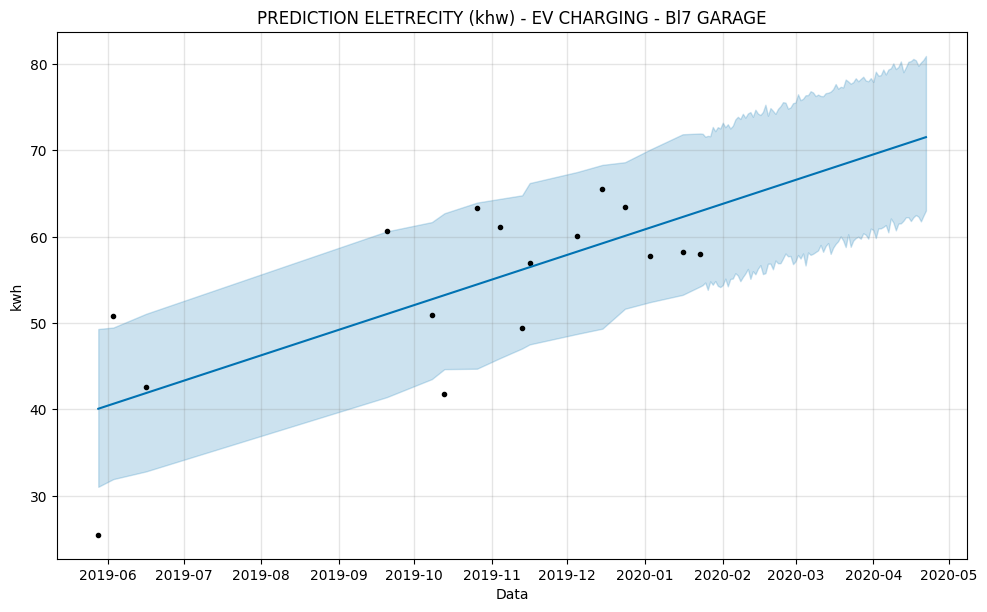

15:40:39 - cmdstanpy - INFO - Chain [1] start processing


data shape: (76, 2)


15:40:39 - cmdstanpy - INFO - Chain [1] done processing


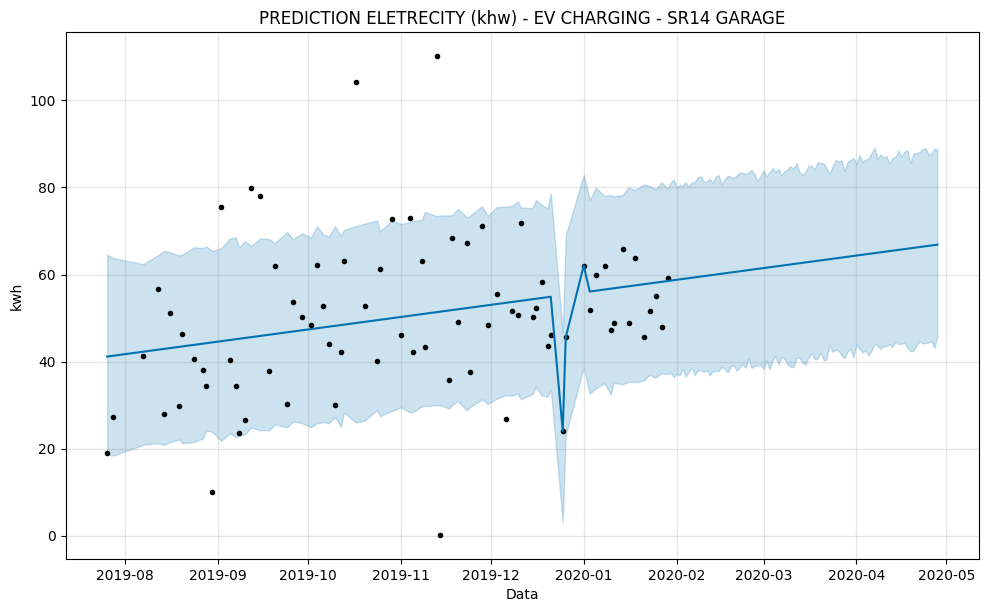

15:40:40 - cmdstanpy - INFO - Chain [1] start processing
15:40:40 - cmdstanpy - INFO - Chain [1] done processing


data shape: (130, 2)


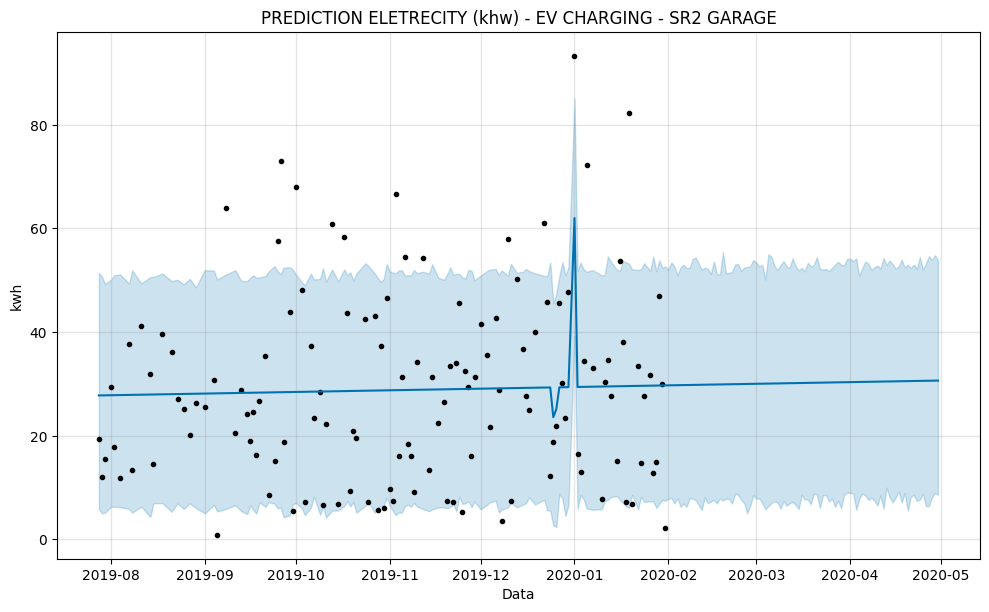

15:40:40 - cmdstanpy - INFO - Chain [1] start processing


data shape: (83, 2)


15:40:40 - cmdstanpy - INFO - Chain [1] done processing


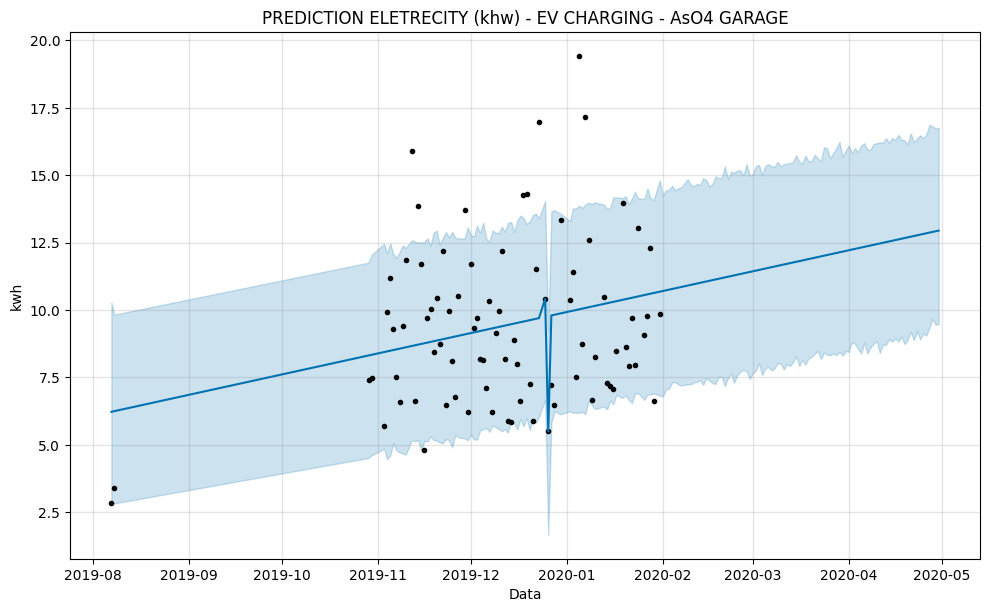

15:40:41 - cmdstanpy - INFO - Chain [1] start processing
15:40:41 - cmdstanpy - INFO - Chain [1] done processing


data shape: (121, 2)


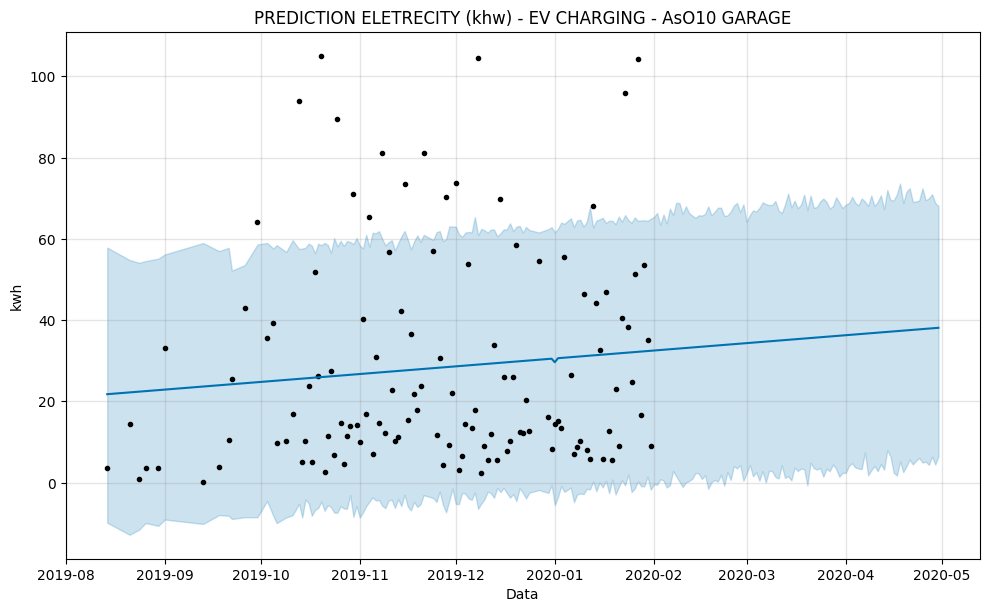

15:40:41 - cmdstanpy - INFO - Chain [1] start processing
15:40:41 - cmdstanpy - INFO - Chain [1] done processing


data shape: (112, 2)


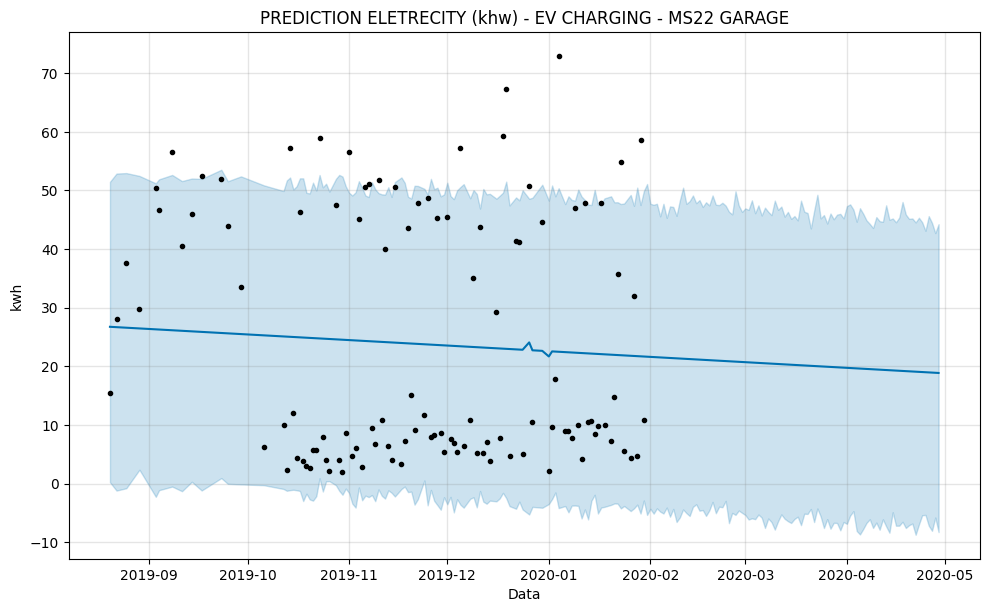

15:40:42 - cmdstanpy - INFO - Chain [1] start processing


data shape: (87, 2)


15:40:42 - cmdstanpy - INFO - Chain [1] done processing


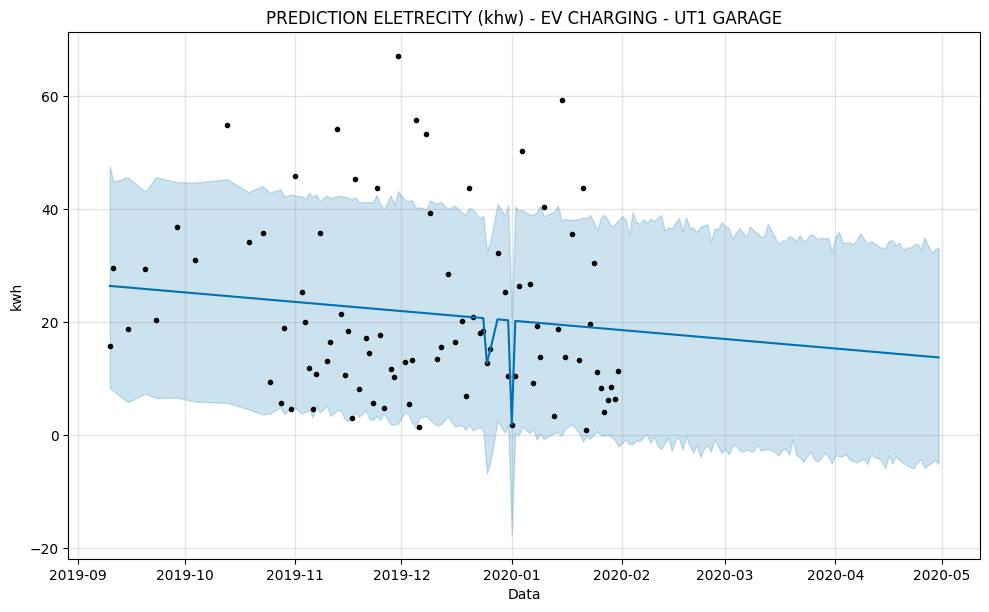

15:40:42 - cmdstanpy - INFO - Chain [1] start processing


data shape: (118, 2)


15:40:43 - cmdstanpy - INFO - Chain [1] done processing


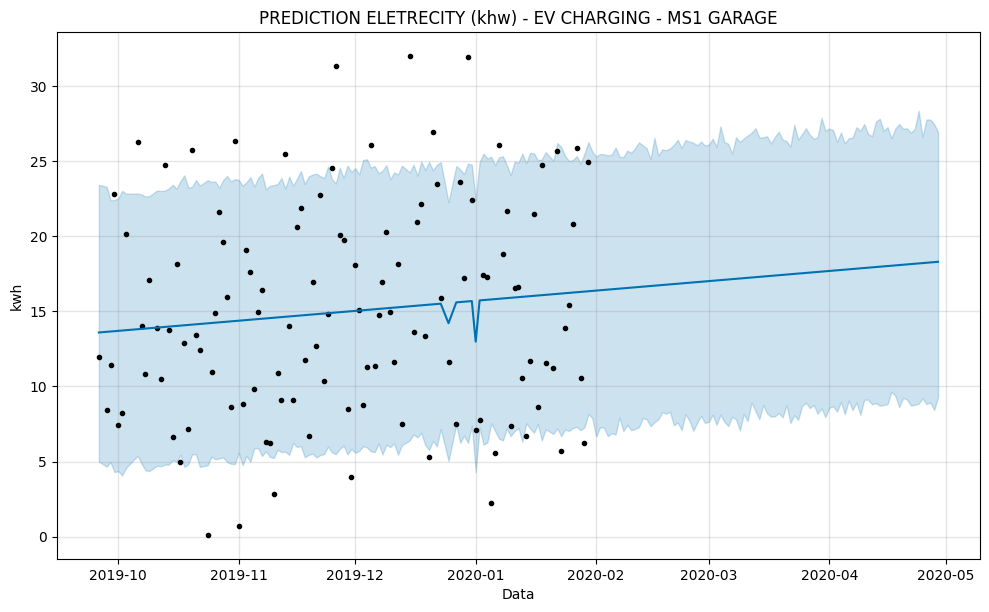

15:40:43 - cmdstanpy - INFO - Chain [1] start processing


data shape: (97, 2)


15:40:43 - cmdstanpy - INFO - Chain [1] done processing


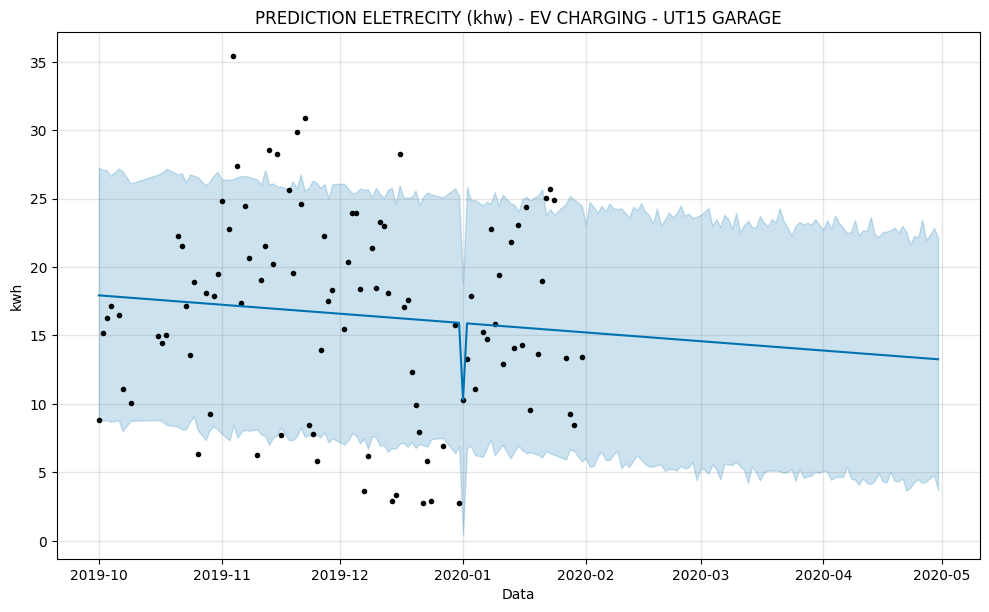

15:40:43 - cmdstanpy - INFO - Chain [1] start processing


data shape: (98, 2)


15:40:44 - cmdstanpy - INFO - Chain [1] done processing


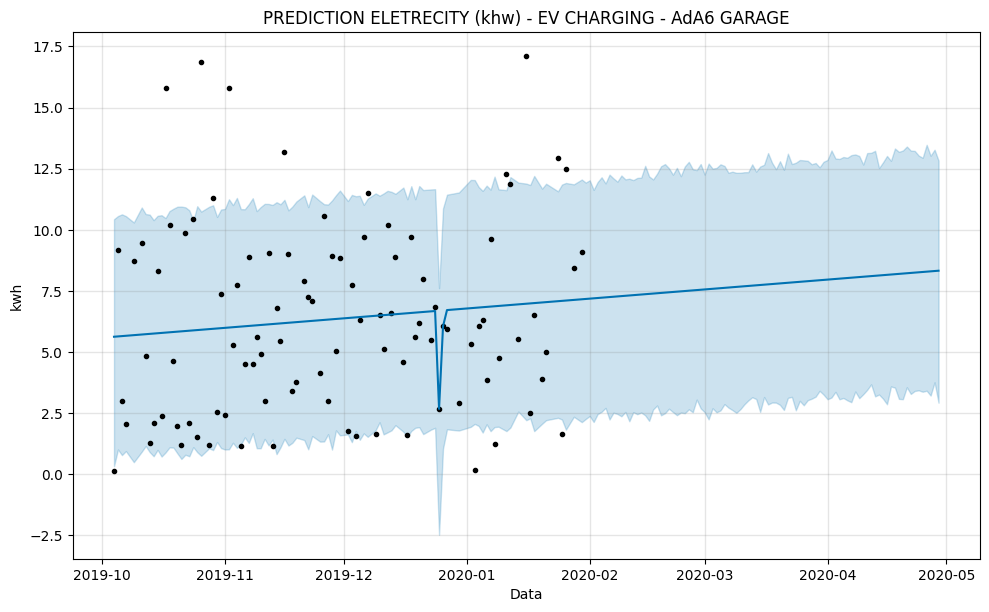

15:40:44 - cmdstanpy - INFO - Chain [1] start processing


data shape: (74, 2)


15:40:44 - cmdstanpy - INFO - Chain [1] done processing


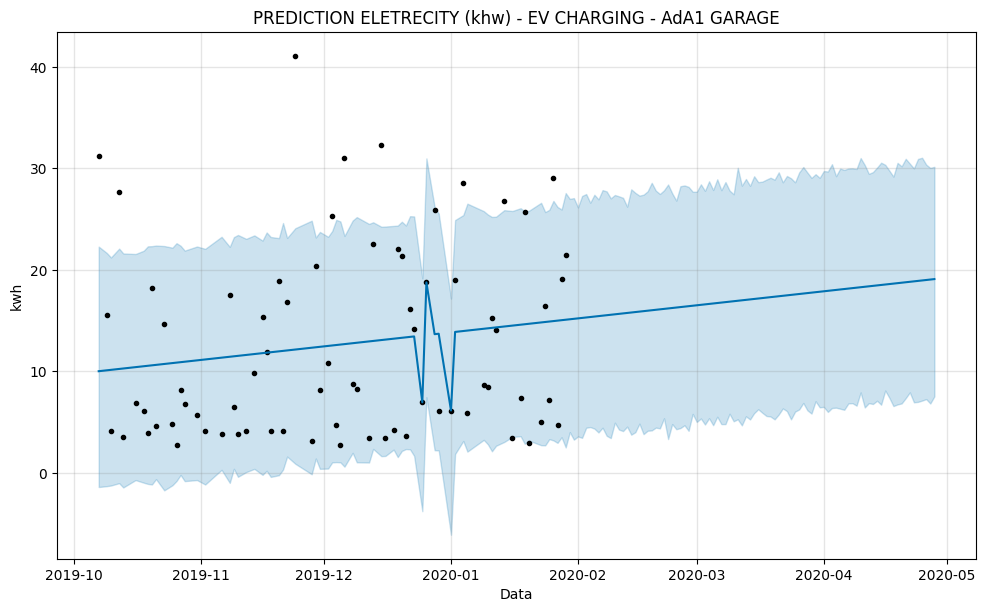

15:40:45 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] done processing


data shape: (112, 2)


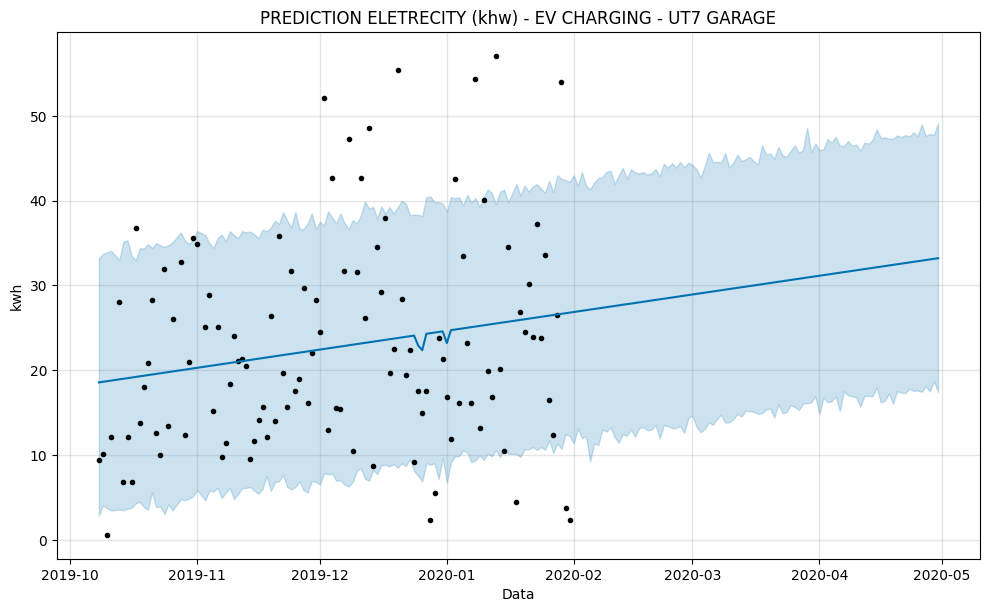

15:40:45 - cmdstanpy - INFO - Chain [1] start processing


data shape: (62, 2)


15:40:45 - cmdstanpy - INFO - Chain [1] done processing


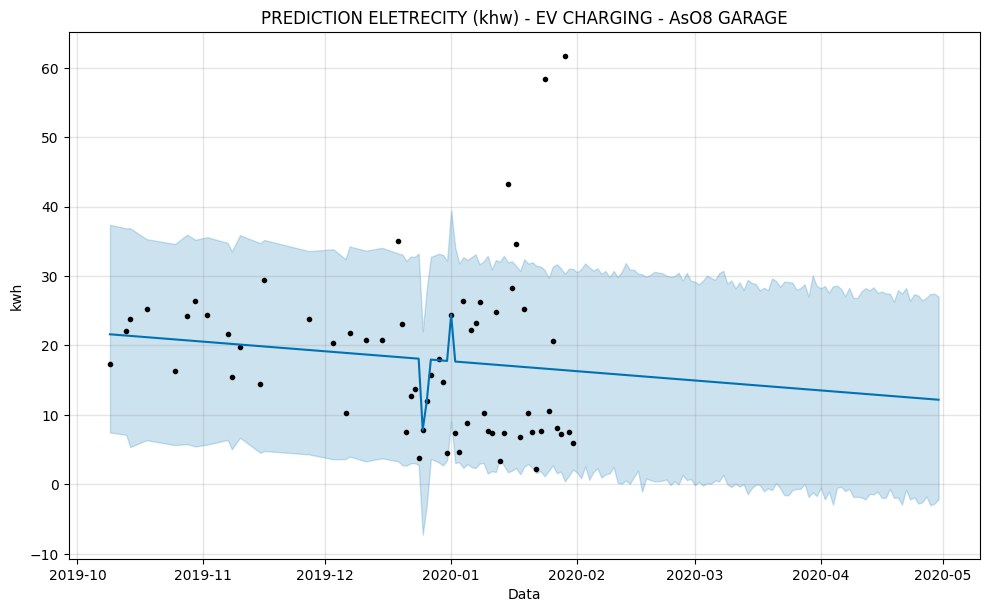

15:40:46 - cmdstanpy - INFO - Chain [1] start processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing


data shape: (104, 2)


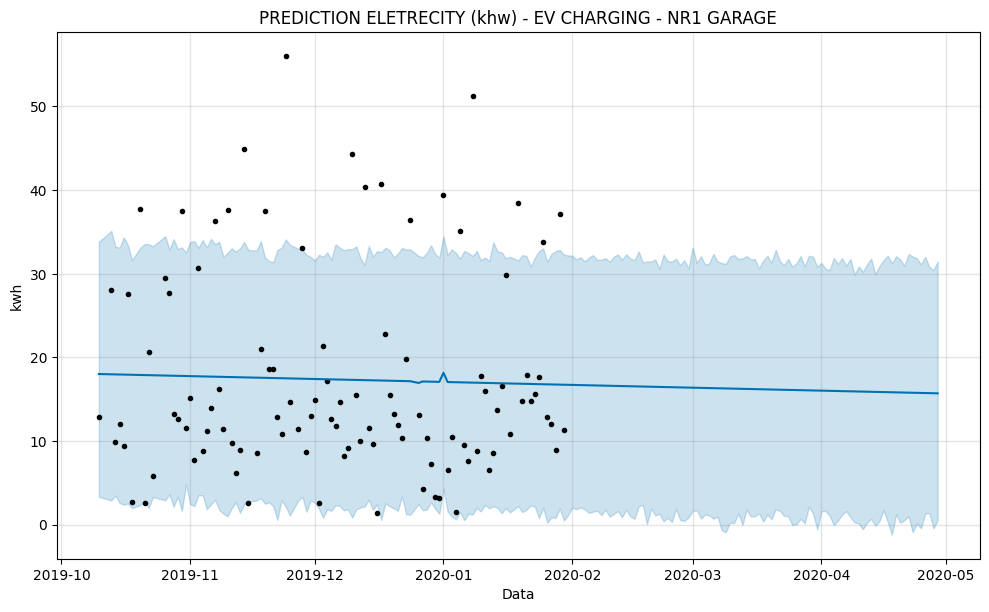

15:40:46 - cmdstanpy - INFO - Chain [1] start processing


data shape: (23, 2)


15:40:46 - cmdstanpy - INFO - Chain [1] done processing


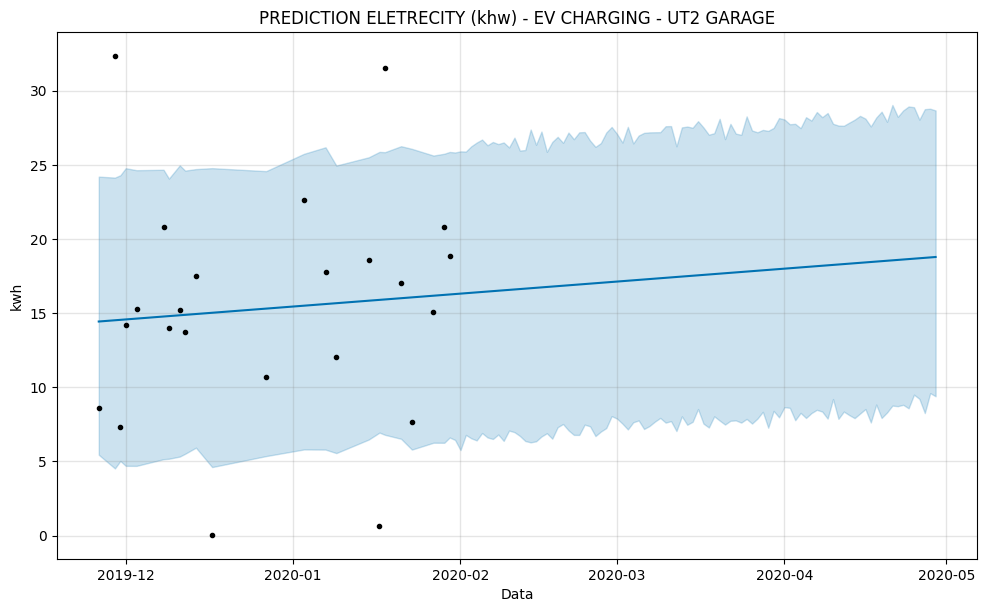

15:40:47 - cmdstanpy - INFO - Chain [1] start processing


data shape: (34, 2)


15:40:47 - cmdstanpy - INFO - Chain [1] done processing


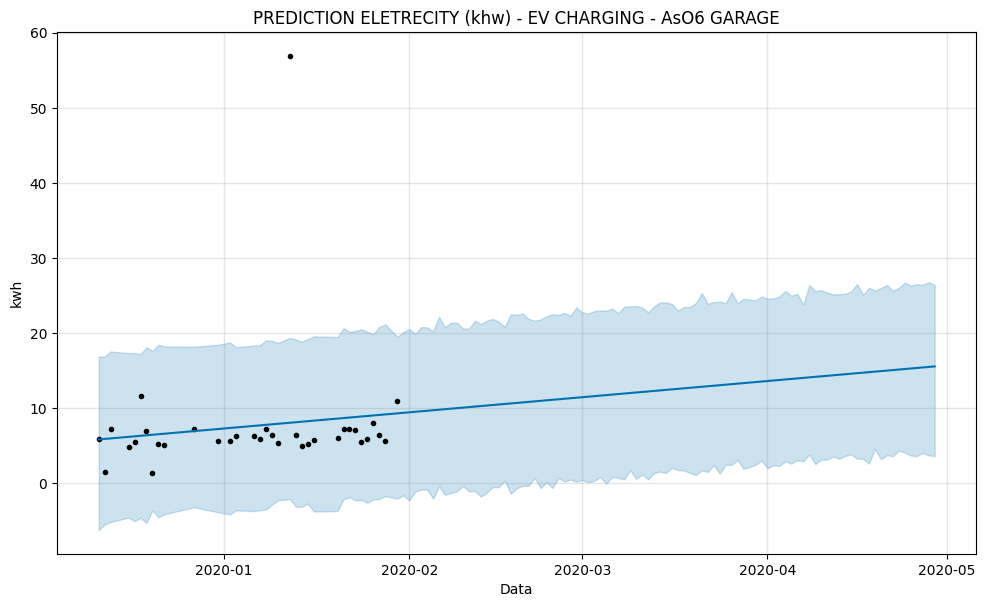

15:40:47 - cmdstanpy - INFO - Chain [1] start processing


data shape: (41, 2)


15:40:47 - cmdstanpy - INFO - Chain [1] done processing


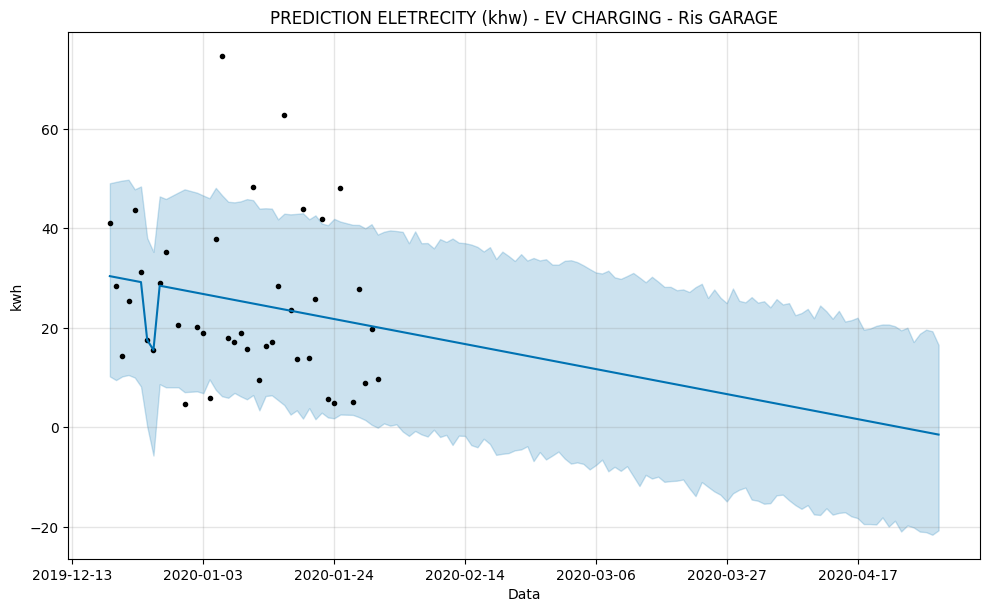

15:40:48 - cmdstanpy - INFO - Chain [1] start processing


data shape: (10, 2)


15:40:48 - cmdstanpy - INFO - Chain [1] done processing


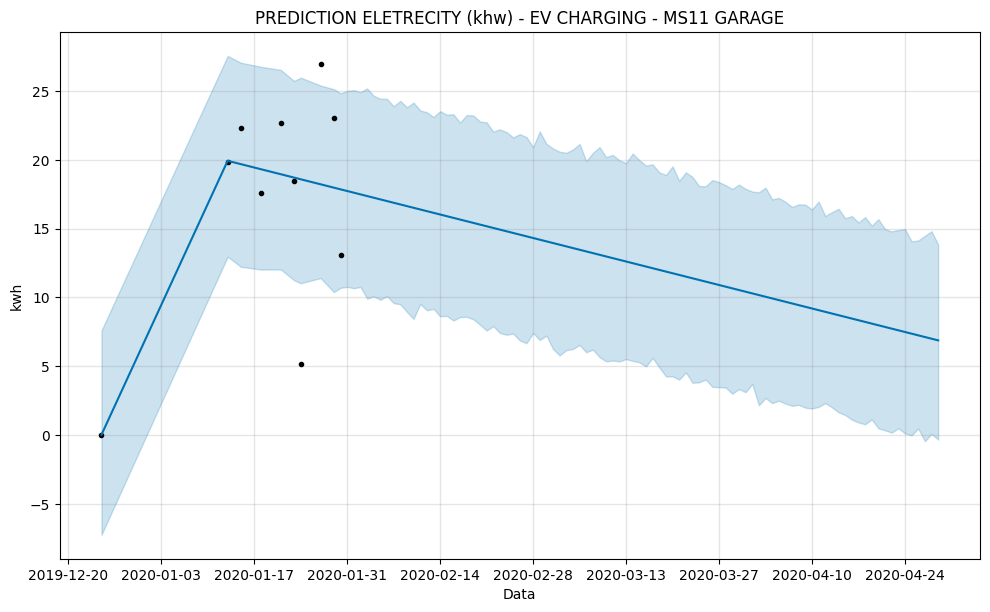

15:40:48 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing


data shape: (6, 2)


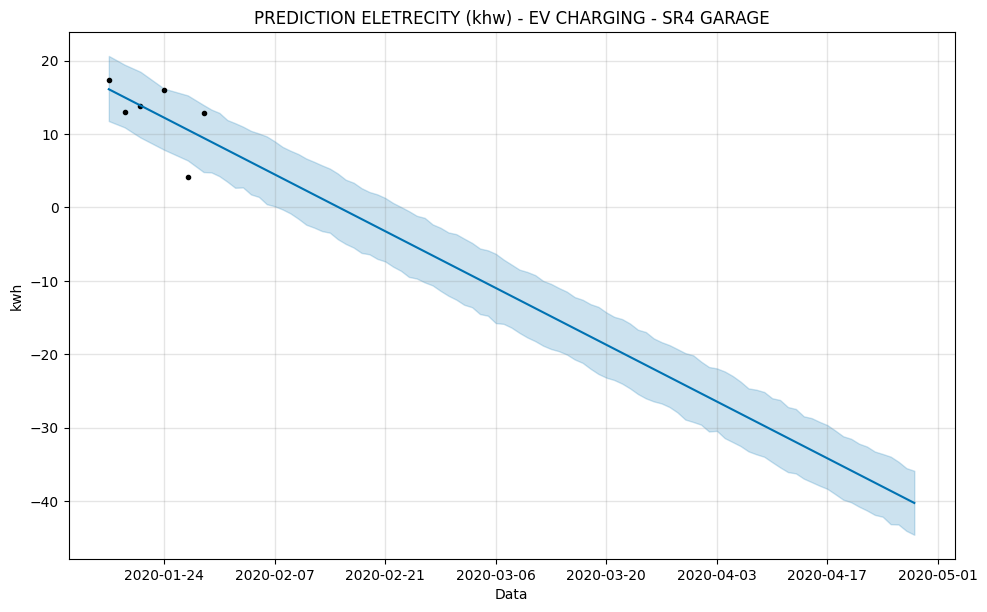

In [1121]:
#PROPHET MODEL FOR ALL DATASETS

for df in time_series_df.values():
    prophet_ts(df)

### ======================= TimeSeries - AUTOARIMA =======================

In [1108]:
# #Executa o AutoArima
# ts_autoarima=auto_arima(time_series_df['AsO8'],
#                     start_p=0,
#                     start_q=0,
#                     d=0,
#                     max_p=6,
#                     max_q=6,
#                     max_d=2,
#                     start_P=1,
#                     start_Q=1,
#                     D=0,
#                     max_P=2, max_D=1, max_Q=2, max_order=5,
#                     seasonal=True, #ok
#                     m=12, #daily data #ok 
#                     trace=True, #ok
#                     error_action='ignore',suppress_warnings=True,
#                     stepwise=True) #ok

# ts_autoarima

In [1109]:
# train_size = int(len(time_series_df['AsO8']) * 0.8) # 80% for training, 20% for testing
# train, test = time_series_df['AsO8'][:train_size], time_series_df['AsO8'][train_size:]

# display(train)
# display(test)

In [1110]:
# train.index = pd.to_datetime(train.index, format='%d.%m.%Y')
# test.index = pd.to_datetime(test.index, format='%d.%m.%Y')

In [1111]:
# ts_autoarima.fit(train)

# pred=ts_autoarima.predict(n_periods=100)
# pred=pd.DataFrame(pred,index=test.index, columns=['pred'])

In [1112]:
# display(pred)
# display(pred.index)

# pd.concat([test,pred],
#           axis=1).plot(linewidth=2,
#                        figsize=(20,7),
#                        color=['g','r'])
# plt.legend(['Consumo de energia','Previsões'], fontsize=15)
# plt.xlabel('Período', size=15)
# plt.title('Previsões X Real',size=15)
# plt.show();